## Stochastic Volatility RBC via Second Order Perturbation

In this notebook I will take the baseline RBC from the DifferentiableStateSpaceModels.jl examples and add a stochastic volatility component. Due to certainty equivalence, this makes no difference when solved at first order, except with modified likelihood as in the NonGaussianRBC notebook, so I will do this using a second order perturbation approach. The model itself should be exactly the same except for the added volatility state.

In [1]:
import Pkg; Pkg.instantiate()

In [3]:
#import Pkg; Pkg.add("Zygote")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IRTools ──── v0.4.7
   Installed GPUArrays ── v8.6.2
   Installed ChainRules ─ v1.46.1
   Installed Zygote ───── v0.6.55
   Installed LLVM ─────── v4.15.0
    Updating `~/Library/CloudStorage/Dropbox/Differentiable Programming/SVBranch/DifferentiableStateSpaceModels.jl/Project.toml`
  [e88e6eb3] + Zygote v0.6.55
    Updating `~/Library/CloudStorage/Dropbox/Differentiable Programming/SVBranch/DifferentiableStateSpaceModels.jl/Manifest.toml`
  [621f4979] + AbstractFFTs v1.2.1
  [fa961155] + CEnum v0.4.2
  [082447d4] + ChainRules v1.46.1
  [0c68f7d7] + GPUArrays v8.6.2
  [7869d1d1] + IRTools v0.4.7
  [929cbde3] + LLVM v4.15.0
  [c1ae055f] + RealDot v0.1.0
  [e88e6eb3] + Zygote v0.6.55
  [dad2f222] + LLVMExtra_jll v0.0.16+0
  [4af54fe1] + LazyArtifacts
Precompiling project...
  ✓ IRTools
  ✓ LLVM
  ✓ ChainRules
  ✓ GPUArrays
  ✓ Zygote
  ✓ DifferentiableStateSpaceModels
  6 dependencie

In [24]:
#import Pkg; Pkg.add("Turing")

   Resolving package versions...
   Installed LRUCache ───────────── v1.4.0
   Installed AdvancedPS ─────────── v0.4.3
   Installed InvertedIndices ────── v1.2.0
   Installed AbstractMCMC ───────── v4.4.0
   Installed Optimisers ─────────── v0.2.14
   Installed Roots ──────────────── v2.0.8
   Installed LogDensityProblemsAD ─ v1.2.1
   Installed NNlib ──────────────── v0.8.17
   Installed MCMCDiagnosticTools ── v0.2.6
   Installed Random123 ──────────── v1.6.0
   Installed Bijectors ──────────── v0.10.6
   Installed Tracker ────────────── v0.2.23
   Installed Libtask ────────────── v0.8.5
   Installed MCMCChains ─────────── v5.7.1
   Installed DynamicPPL ─────────── v0.21.6
   Installed Turing ─────────────── v0.24.0
   Installed AdvancedVI ─────────── v0.1.6
   Installed AdvancedMH ─────────── v0.7.2
   Installed MLJModelInterface ──── v1.8.0
   Installed DistributionsAD ────── v0.6.43
   Installed AbstractPPL ────────── v0.5.3
   Installed TerminalLoggers ────── v0.1.6
   Installed A

The model here is the same, economically as the one in the NonGaussianRBC notebook, an RBC plus an AR(1) stochastic volatility, now log-normally distributed. 

The key technical modification here is some manipulation of state variables to get the model into Schmitt-Grohe Uribe form. This means that, to allow the TFP shocks to enter nonlinearly (here, multiplied by a random variance), one must add a state variable to represent them (called $\zeta$ here. Further, because volatilities affect TFP contemporaneously (it's not a news shock, though we could modify timing to make it anticipated if we wanted) we need to turn TFP into a jump variable, and add its lag as a state to capture persistence.

In [12]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, DiffEqBase, Symbolics, Plots, Random, StatsPlots

In [13]:
#Build the RBC model
∞ = Inf
@variables α, β, ρ, δ, σ, Ω_1, ρ_σ, μ_σ, σ_σ
@variables t::Integer, k(..), z(..), zlag(..), c(..), q(..), ν(..), ζ(..)

x = [k, zlag, ν, ζ] # states
y = [c, q, z] # controls
p = [α, β, ρ, δ, σ, Ω_1, ρ_σ, μ_σ, σ_σ] # parameters

# system of model equations
H = [1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)^(α - 1) + (1 - δ)),
     c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
     q(t) - exp(z(t)) * k(t)^α,
     z(t) - ρ * zlag(t) - exp(ν(t)) * ζ(t), #Add time-varying volatility
     ν(t + 1) - ρ_σ * ν(t) - (1 - ρ_σ) * μ_σ, #Persistence process for volatility shock
     ζ(t+1), #Have to turn TFP shock into a state to allow it to enter nonlinearly  
     zlag(t+1) - z(t)] #Augment TFP process with lags so volatility can enter contemporaneously


# analytic solutions for the steady state.  Could pass initial values and run solver and use initial values with steady_states_iv
steady_states = [k(∞) ~ (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 zlag(∞) ~ 0,
                 ν(∞) ~ μ_σ,
                 ζ(∞) ~ 0,
                 c(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)) -
                        δ * (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 q(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)),
                 z(∞) ~ 0]


Γ = [σ 0;
     0 σ_σ] # standard dev matrix for the 2 shocks.  
η = [0    0;
     0    0;
     0    -1.0;
     -1.0 0] # η is n_x * n_ϵ matrix.  

# observation matrix.  order is "y" then "x" variables, so [c,q,z,k,zlag,ν,ζ] in this example
Q = [1.0 0 0 0   0 0 0; # select c as first "z" observable
     0   0 0 1.0 0 0 0] # select k as second "z" observable

# diagonal cholesky of covariance matrix for observation noise (so these are standard deviations).  Non-diagonal observation noise not currently supported
Ω = [Ω_1, Ω_1]

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache  = true
model_rbc = @make_and_include_perturbation_model("rbc_sv_example", H, (; t, y, x, p, steady_states, Γ, Ω, η, Q, overwrite_model_cache)) # Convenience macro.  Saves as ".function_cache/rbc_sv_example.jl"

Building model up to order 2
Substituting and simplifying
Building model functions
Saved rbc_sv_example to /Users/dchilder/Library/CloudStorage/Dropbox/Differentiable Programming/SVBranch/DifferentiableStateSpaceModels.jl/.function_cache/rbc_sv_example.jl


Perturbation Model: n_y = 3, n_x = 4, n_p = 9, n_ϵ = 2, n_z = 2
 y = [:c, :q, :z] 
 x = [:k, :zlag, :ν, :ζ] 
 p = [:α, :β, :ρ, :δ, :σ, :Ω_1, :ρ_σ, :μ_σ, :σ_σ]

In [14]:
model_H_latex(model_rbc)

"\$\\begin{equation}\n\\left[\n\\begin{array}{c}\n\\frac{ - \\beta \\left( 1 - \\delta + \\left( k\\left( 1 + t \\right) \\right)^{-1 + \\alpha} \\alpha e^{z\\left( 1 + t \\right)} \\right)}{c\\left( 1 + t \\right)} + \\frac{1}{c\\left( t \\right)} \\\\\n - q\\left( t \\right) - \\left( 1 - \\delta \\rig" ⋯ 237 bytes ⋯ "right)} + z\\left( t \\right) \\\\\n - \\mu_{\\sigma} \\left( 1 - \\rho_{\\sigma} \\right) - \\rho_{\\sigma} \\nu\\left( t \\right) + \\nu\\left( 1 + t \\right) \\\\\n\\zeta\\left( 1 + t \\right) \\\\\n - z\\left( t \\right) + \\mathrm{zlag}\\left( 1 + t \\right) \\\\\n\\end{array}\n\\right]\n\\end{equation}\n\$"

In [15]:
model_steady_states_latex(model_rbc)  # this is the closed form steady state

"\$\\begin{align}\nk\\left( \\infty \\right) =& \\left( \\frac{-1 + \\delta + \\frac{1}{\\beta}}{\\alpha} \\right)^{\\frac{1}{-1 + \\alpha}} \\\\\n\\mathrm{zlag}\\left( \\infty \\right) =& 0 \\\\\n\\nu\\left( \\infty \\right) =& \\mu_{\\sigma} \\\\\n\\zeta\\left( \\infty \\right) =& 0 \\\\\nc\\left( \\infty \\right" ⋯ 78 bytes ⋯ "}{-1 + \\alpha}} - \\left( \\frac{-1 + \\delta + \\frac{1}{\\beta}}{\\alpha} \\right)^{\\frac{1}{-1 + \\alpha}} \\delta \\\\\nq\\left( \\infty \\right) =& \\left( \\frac{-1 + \\delta + \\frac{1}{\\beta}}{\\alpha} \\right)^{\\frac{\\alpha}{-1 + \\alpha}} \\\\\nz\\left( \\infty \\right) =& 0\n\\end{align}\n\$"

In [16]:
@show model_rbc.n_x, model_rbc.n_y, model_rbc.n_ϵ, model_rbc.n_z

(model_rbc.n_x, model_rbc.n_y, model_rbc.n_ϵ, model_rbc.n_z) = (4, 3, 2, 2)


(4, 3, 2, 2)

In [17]:
#Solve model at some fixed parameters
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01, ρ_σ = 0.5, μ_σ = 1.0, σ_σ = 0.1) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
m = model_rbc  # ensure notebook executed above
sol = generate_perturbation(model_rbc, p_d, p_f, Val(2)); # Solution to the second-order RBC
@show sol.retcode, verify_steady_state(m, p_d, p_f) # the final call checks that the analytically provided steady-state solution is correct

(sol.retcode, verify_steady_state(m, p_d, p_f)) = (:Success, true)


(:Success, true)

In [19]:
@show sol.g_x # the policy

sol.g_x = [0.09579643002416066 0.13493739305169403 0.0 1.8339893175602788; 0.07263157894736896 1.3768115942029018 -0.0 18.712809688667384; -1.4338810397209697e-34 0.19999999999999996 0.0 2.7182818284590446]


3×4 Matrix{Float64}:
  0.0957964    0.134937   0.0   1.83399
  0.0726316    1.37681   -0.0  18.7128
 -1.43388e-34  0.2        0.0   2.71828

In [20]:
@show sol.x_ergodic_var

sol.x_ergodic_var = [0.5176337615471391 0.005910359467584125 0.0 0.0; 0.005910359467584125 0.0007696933436386119 0.0 0.0; 0.0 0.0 0.013333333333333336 0.0; 0.0 0.0 0.0 0.00010000000000000011]


4×4 Matrix{Float64}:
 0.517634    0.00591036   0.0        0.0
 0.00591036  0.000769693  0.0        0.0
 0.0         0.0          0.0133333  0.0
 0.0         0.0          0.0        0.0001

In [21]:
# Simulate T observations
T = 20
x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = QuadraticStateSpaceProblem(sol, x_iv, (0, T))
sim = solve(problem, DirectIteration())
ϵ = sim.W # store the underlying noise in the simulation

# Collapse to simulated observables as a matrix  - as required by current DifferenceEquations.jl likelihood
# see https://github.com/SciML/DifferenceEquations.jl/issues/55 for direct support of this datastructure
z_rbc = hcat(sim.z...) 

2×21 Matrix{Float64}:
 -0.0323286    -0.0115466  -0.0141667  …  0.0544209  0.0525044  0.0541295
  0.000660387  -0.192617   -0.127089      0.598898   0.789239   0.72354

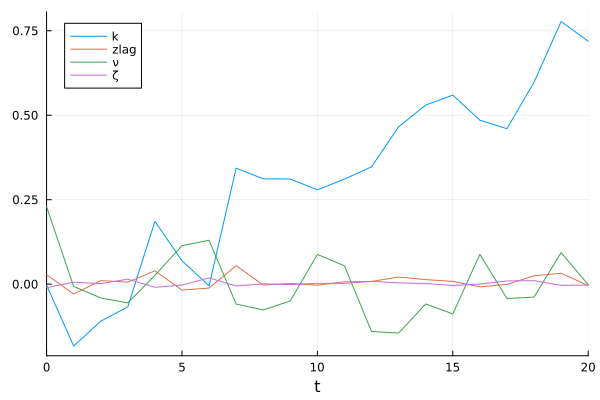

In [22]:
plot(sim)

In [25]:
using Turing
using Turing: @addlogprob!
Turing.setadbackend(:zygote);  # Especially when we sample the latent noise, we will require high-dimensional gradients with reverse-mode AD

In [27]:
# Turing model definition
@model function rbc_2_joint(z, m, p_f, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0) # add noise to the estimation
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(2); cache, settings)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = QuadraticStateSpaceProblem(sol, zeros(m.n_x), (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf
end
cache = SolverCache(model_rbc, Val(2),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
z = z_rbc # simulated in previous steps
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01, ρ_σ = 0.5, μ_σ = 1.0, σ_σ = 0.1) # Fixed parameters
turing_model = rbc_2_joint(z, model_rbc, p_f, cache, settings) # passing observables from before 

n_samples = 300
n_adapts = 50
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_2_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:24:18


Chains MCMC chain (300×56×1 Array{Float64, 3}):

Iterations        = 51:1:350
Number of chains  = 1
Samples per chain = 300
Wall duration     = 1645.56 seconds
Compute duration  = 1645.56 seconds
parameters        = α, β, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21], ϵ_draw[22], ϵ_draw[23], ϵ_draw[24], ϵ_draw[25], ϵ_draw[26], ϵ_draw[27], ϵ_draw[28], ϵ_draw[29], ϵ_draw[30], ϵ_draw[31], ϵ_draw[32], ϵ_draw[33], ϵ_draw[34], ϵ_draw[35], ϵ_draw[36], ϵ_draw[37], ϵ_draw[38], ϵ_draw[39], ϵ_draw[40], ϵ_draw[41], ϵ_draw[42]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       

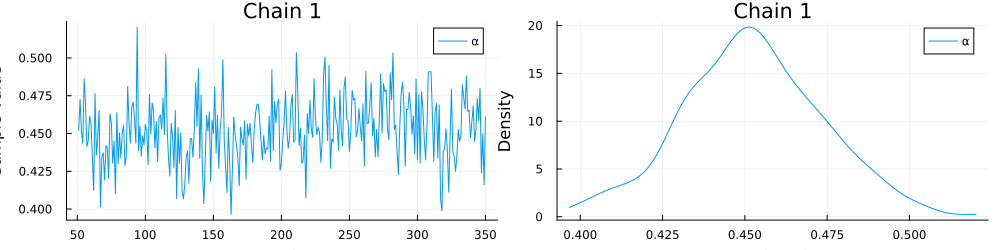

In [28]:
#Plot the chains and posteriors
plot(chain_2_joint[["α"]]; colordim=:parameter, legend=true)

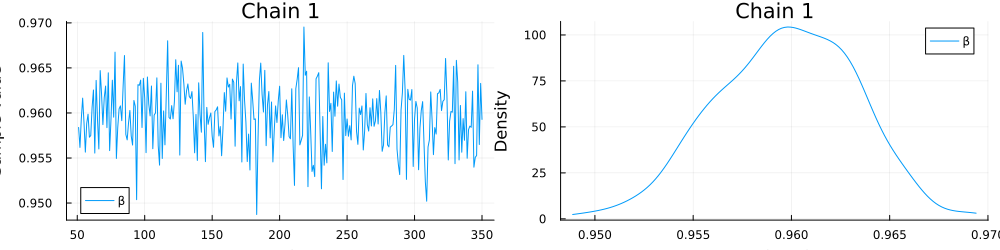

In [29]:
plot(chain_2_joint[["β"]]; colordim=:parameter, legend=true)

In [30]:
ϵ

2×20 Matrix{Float64}:
 -0.609358  -0.15499  -1.48952    0.908728  …  -1.04823    0.346872  0.284922
  1.21258    0.37492   0.349784  -0.537237      0.170797  -1.12742   0.484293

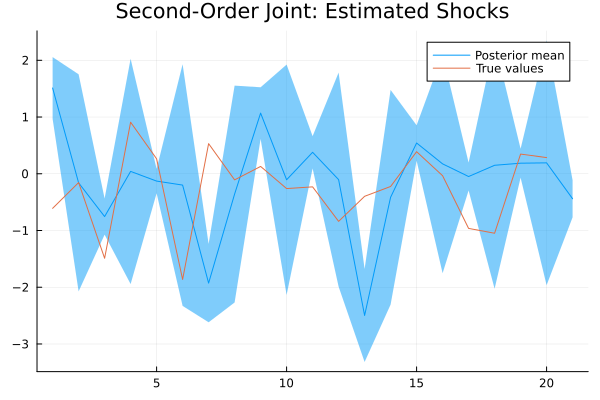

In [32]:
#Plot true and estimated latents to see how well we backed them out
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_2_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[1:end], ribbon=2 * ϵ_std[1:end], label="Posterior mean", title = "Second-Order Joint: Estimated Shocks")
plot!(ϵ[1,:], label="True values")

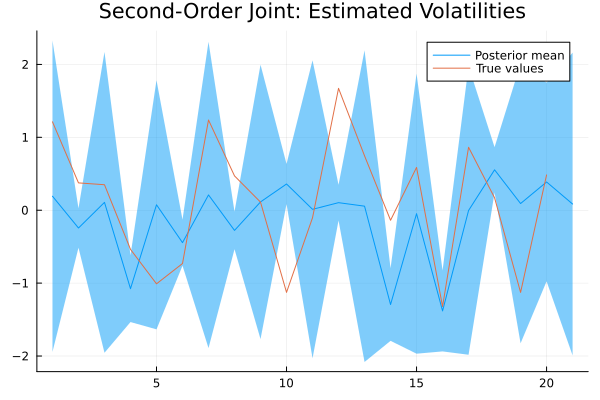

In [33]:
#Plot true and estimated volatilities to see how well we backed them out
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_2_joint[:, [Symbol("ϵ_draw[$a]") for a in 22:42], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[1:end], ribbon=2 * ϵ_std[1:end], label="Posterior mean", title = "Second-Order Joint: Estimated Volatilities")
plot!(ϵ[2,:], label="True values")

I'm pretty sure I have these series misaligned due to the initial conditions being missing, so true and estimated values are off from eachother by one dimension. Fix that later.